# 1.0.2: Assign cross-validation folds using spatial CV


As mentioned in the previous notebook, assessing the generalizability of models trained to predict values that are potentially spatially correlated can be problematic when done with traditional "random" K-Fold cross-validation (CV), but we can try to overcome this by first binning our training data to hexagonal grid cells with a side length of the response variable's spatial autocorrelation range, and then assigning folds to bins instead of directly to individual data points. This then minimizes the likelihood that we ever have train and test data data that are spatially autocorrelated.

The next step in the process, then, is to generate the bins according to the autocorrelation ranges of the response variables that we calculated in the previous notebook.


## Imports and config


In [1]:
import logging
from pathlib import Path
from typing import Sequence

import cartopy.crs as ccrs
import dask
import dask.bag as db
import dask.dataframe as dd
from dask.distributed import Client
import geopandas as gpd
from h3 import h3
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
from scipy.stats import ks_2samp
from shapely.geometry import Polygon

from src.conf.conf import get_config
from src.conf.environment import log

pd.set_option("display.max_columns", None)

cfg = get_config()

train_dir = Path(cfg.train.dir) / cfg.PFT / cfg.model_res / cfg.datasets.Y.use

## Load the data

### Autocorrelation ranges (ACR)


First let's load the autocorrelation ranges (ACR) that we calculated in the last notebook. Remember, we calculated ACR for each UTM zone, and then generated the following statistics from those ranges.


In [2]:
ranges = pd.read_parquet(train_dir / cfg.train.spatial_autocorr)
ranges.head()

,trait,mean,std,median,q05,q95
0,X4_mean,343638.717288,356010.419360,161481.046785,11154.639738,985459.064594
1,X6_mean,316666.164360,365769.761596,78795.582067,6448.380981,973600.562413
2,X11_mean,373180.581587,353636.705577,237848.494012,575.049854,990482.310816
3,X13_mean,419451.326059,355805.950772,304311.690925,1542.965743,996200.233414
4,X14_mean,375226.277820,370134.411584,210748.876001,591.618365,998249.711124


### Features (trait data)


In order to generate the hex-bin folds, we'll need to also load the XY coordinates for the features. Let's select only the traits and their XY coordinates, and then for ease of notebook-processing, we'll select only a single trait and sample 1% of the data.


In [3]:
feat_cols = dd.read_parquet(train_dir / cfg.train.features).columns

# Only select "x", "y", and all other columns starting with "X"
feat_cols = feat_cols[feat_cols.str.match(r"^(x|y|X\d+)")].tolist()

feats_samp = (
    dd.read_parquet(train_dir / cfg.train.features, columns=["x", "y", "X4_mean"])
    .sample(frac=0.01)
    .reset_index(drop=True)
    .compute()
)
print(f"feats_samp shape: {feats_samp.shape}")
feats_samp.head()

feats_samp shape: (48277, 3)


,x,y,X4_mean
0,5.255,50.865,0.465882
1,-106.615,35.425,0.439587
2,-4.005,37.605,0.515943
3,5.255,43.845,0.544137
4,-86.815,33.165,0.524494


In [4]:
# Get row where trait = "X4_mean"
ranges = ranges[ranges["trait"] == "X4_mean"]
ranges

,trait,mean,std,median,q05,q95
0,X4_mean,343638.717288,356010.41936,161481.046785,11154.639738,985459.064594


## Bin the data with a hex grid


In order to bin the points, we'll need to define a grid of hexagons with a radius (or apothem) of half the trait's autocorrelation (AC) range. If we were to use a regular square grid with a side length of the autocorrelation range (which is in meters), we would end up with severe distortion toward the poles. To solve for this we can generate a spatially-consistent hexgrid using the `h3` package developed by the gig-based amateur "taxi" company Uber.

With `h3`, we can pass a set of lat/lon coordinates and a "resolution", and in return we get its corresponding hexagon. The way resolution is used to generate the hex grids is quite complicated (see https://h3geo.org), but they do provide a lookup table which links "resolution" to hexagon edge length in kilometers.

| Res | Average edge length (Km) |
| --- | ------------------------ |
| 0   | 1281.256011              |
| 1   | 483.0568391              |
| 2   | 182.5129565              |
| 3   | 68.97922179              |
| 4   | 26.07175968              |
| 5   | 9.854090990              |
| 6   | 3.724532667              |
| 7   | 1.406475763              |
| 8   | 0.531414010              |
| 9   | 0.200786148              |
| 10  | 0.075863783              |
| 11  | 0.028663897              |
| 12  | 0.010830188              |
| 13  | 0.004092010              |
| 14  | 0.001546100              |
| 15  | 0.000584169              |

Even though it's not well documented on their website, `h3.geo_to_h3` can accept floats as resolutions. Because our AC ranges will vary, it would be nice to be able to programmatically select a resolution that is as precise as possible. To do this, we can fit a logarithmic function to the table data to always get the right resolution given an edge length.


In [5]:
# Resolution levels
resolutions = np.arange(16)

# Corresponding edge lengths
edge_lengths = np.array(
    [
        1281.256011,
        483.0568391,
        182.5129565,
        68.97922179,
        26.07175968,
        9.854090990,
        3.724532667,
        1.406475763,
        0.531414010,
        0.200786148,
        0.075863783,
        0.028663897,
        0.010830188,
        0.004092010,
        0.001546100,
        0.000584169,
    ]
)

# Fit a logarithmic function to the data
coeffs = np.polyfit(np.log(edge_lengths), resolutions, deg=1)


# Function to get the resolution for a given edge length
def get_resolution(edge_length):
    return np.polyval(coeffs, np.log(edge_length))


# Test the function
edge_length = 10
resolution = get_resolution(edge_length)
print(
    f"The approximate H3 resolution for an edge length of {edge_length} km is {resolution}."
)

The approximate H3 resolution for an edge length of 10 km is 4.98469543633173.


Now, we have maximum ACRs don't really correspond only to the hexagons' edge lengths ($EL$), but more to their "diameters". While technically hexagons don't actually have diameters, we can say that the ACR is equal to 2x the apothem, or radius ($r$), which gives us this equation for $EL$:

$EL = \frac{ACR}{\sqrt{3}}$

This means we can modify our definition of `edge_length` accordingly:


In [6]:
def get_edge_length(acr: int | float) -> int | float:
    return (acr / 1000) / np.sqrt(3)

In [7]:
edge_length = get_edge_length(ranges["median"].values[0])
x4_res = get_resolution(edge_length)
print(f"X4 resolution: {x4_res}")

X4 resolution: 2.690958393624414


Now that we know our resolution, we can assign hexagons to each observation in our trait features using `h3.geo_to_h3`, which takes a latitude, longitude, and resolution arguments and returns a hexadecimal ID for the corresponding hexagon. Note that, as we want to efficiently apply it to our entire dataframe, we can first vectorize the function using `np.vectorize`, which allows us to then pass the entire latitude (`y`) and longitude (`x`) series at once.


In [8]:
def assign_hexagon(df: pd.DataFrame, resolution) -> pd.DataFrame:
    geo_to_h3_vectorized = np.vectorize(h3.geo_to_h3)
    df["hex_id"] = geo_to_h3_vectorized(df["y"], df["x"], resolution)
    return df


df = assign_hexagon(feats_samp.copy(), x4_res)
df.head()

,x,y,X4_mean,hex_id
0,5.255,50.865,0.465882,821fa7fffffffff
1,-106.615,35.425,0.439587,8248dffffffffff
2,-4.005,37.605,0.515943,82391ffffffffff
3,5.255,43.845,0.544137,82396ffffffffff
4,-86.815,33.165,0.524494,8244effffffffff


Next, we want to randomly assign folds from $0 \text{ to } n-1$ to the `hex_id`s. But a simple random assignment may not be enough. What if our random assignment results in some folds containing a significantly different distribution of trait data from others? We want to tease out spatial autocorrelation, but we don't necessarily want our train and test sets to contain data that is very differently distributed, otherwise we risk overfitting. One way to address this is to randomly assign folds to hex IDs multiple times, and compare the fold distributions of each "simulation" using a Kolmogorov-Smirnov test. We can then choose the simulation that results in the highest $p$-value (which essentially means the distributions are more similar).

One more issue for us--our combined sPlot and GBIF (mostly the GBIF) trait data at 0.01 degree resolution is pretty big. Here we'll use `dask` to parallelize some of the more intensive operations, such as the KS test, as well as the simulations.

**Note:** This code requires that the entire `DataFrame` can fit into memory. If that's not the case, then try sampling it at a lower fraction above.


### Assign folds with similarity assessment (Dask)


In [17]:
def get_loggers_starting_with(s):
    return [
        name
        for name, logger in logging.Logger.manager.loggerDict.items()
        if name.startswith(s)
    ]


distributed_loggers = get_loggers_starting_with("distributed")

# Set the level of all these loggers
for logger_name in distributed_loggers:
    logging.getLogger(logger_name).setLevel(logging.WARNING)


def calculate_kg_p_value(
    df: pd.DataFrame, data_col: str, fold_i: int, fold_j: int
) -> float:
    fold_i_values = df[df["fold"] == fold_i][data_col]
    fold_j_values = df[df["fold"] == fold_j][data_col]
    _, p_value = ks_2samp(fold_i_values, fold_j_values)
    return p_value


def calculate_similarity_kg(folds: Sequence, df: pd.DataFrame, data_col: str) -> float:
    # Use Dask's delayed function to parallelize the pairwise comparisons
    p_values = [
        dask.delayed(calculate_kg_p_value)(df, data_col, folds[i], folds[j])
        for i in range(len(folds))
        for j in range(i + 1, len(folds))
    ]

    # Compute the p-values in parallel
    p_values = dask.compute(*p_values)

    similarity = np.min(p_values)
    return similarity


def assign_folds_iteration(args):
    try:
        df, n_folds, data_col, hexagons, i = args
        np.random.shuffle(hexagons)
        folds = np.array_split(hexagons, n_folds)
        for j, fold in enumerate(folds):
            df.loc[df["hex_id"].isin(fold), "fold"] = j

        similarity = calculate_similarity_kg(range(n_folds), df, data_col)
        return similarity, df["fold"].copy()
    except Exception as e:
        log.error(f"Error in assign_folds_iteration: {e}")
        raise


def assign_folds(
    df: pd.DataFrame, n_folds: int, n_iterations: int, data_col: str
) -> pd.DataFrame:
    hexagons = df["hex_id"].unique()
    best_similarity = None
    best_assignment = pd.Series(dtype=int)

    with Client(dashboard_address=cfg.dask_dashboard):
        results = (
            db.from_sequence(
                [(df, n_folds, data_col, hexagons, i) for i in range(n_iterations)]
            )
            .map(assign_folds_iteration)
            .compute()
        )

    for similarity, assignment in results:
        if best_similarity is None or similarity > best_similarity:
            best_similarity = similarity
            best_assignment = assignment

    log.info(f"Best similarity: {best_similarity}")
    df["fold"] = best_assignment.astype(int)
    return df

In [18]:
n_folds = 10
n_iterations = 100

df = assign_folds(df, n_folds, n_iterations, "X4_mean")

2024-05-20 11:37:57 CEST - src.conf.environment - INFO - Best similarity: 3.3778539874040443e-08


Even with 100 simulations, the least similar folds in our best run remain significantly dissimilar ($p << 0.05$). This doesn't mean that all of the folds in this run are so dissimilar from each other, but it does mean that at least two of them are. We could try increasing the number of simulations, but at some point a tradeoff must be made between computation time and fold similarity.


In [15]:
df.head()

,x,y,X4_mean,hex_id,fold
0,5.255,50.865,0.465882,821fa7fffffffff,8
1,-106.615,35.425,0.439587,8248dffffffffff,0
2,-4.005,37.605,0.515943,82391ffffffffff,8
3,5.255,43.845,0.544137,82396ffffffffff,2
4,-86.815,33.165,0.524494,8244effffffffff,5


In [41]:
def get_splits(
    df: pd.DataFrame, data_col: str
) -> list[tuple[npt.NDArray[np.int64], npt.NDArray[np.int64]]]:
    splits = []
    folds = df["fold"].unique()
    for fold in folds:
        train = df[df["fold"] != fold].index.to_numpy()
        test = df[df["fold"] == fold].index.to_numpy()
        splits.append((train, test))
    return splits


splits = get_splits(df, "X4_mean")
for split in splits:
    print(
        f"Train: {len(split[0])}, Test: {len(split[1])}, Test pct: {len(split[1]) / len(df):.2%}"
    )

Train: 43332, Test: 4945, Test pct: 10.24%
Train: 42739, Test: 5538, Test pct: 11.47%
Train: 43199, Test: 5078, Test pct: 10.52%
Train: 43551, Test: 4726, Test pct: 9.79%
Train: 44526, Test: 3751, Test pct: 7.77%
Train: 43173, Test: 5104, Test pct: 10.57%
Train: 42696, Test: 5581, Test pct: 11.56%
Train: 42715, Test: 5562, Test pct: 11.52%
Train: 44249, Test: 4028, Test pct: 8.34%
Train: 44313, Test: 3964, Test pct: 8.21%


## Plot the final hex bins


Finally, plot the resulting hex bin assignments along with the points (note that, due to plotting difficulties with hexagons that span the antimeridian, I've chosen to simply hide them for now--don't worry, the points in those locations still have hexagons).


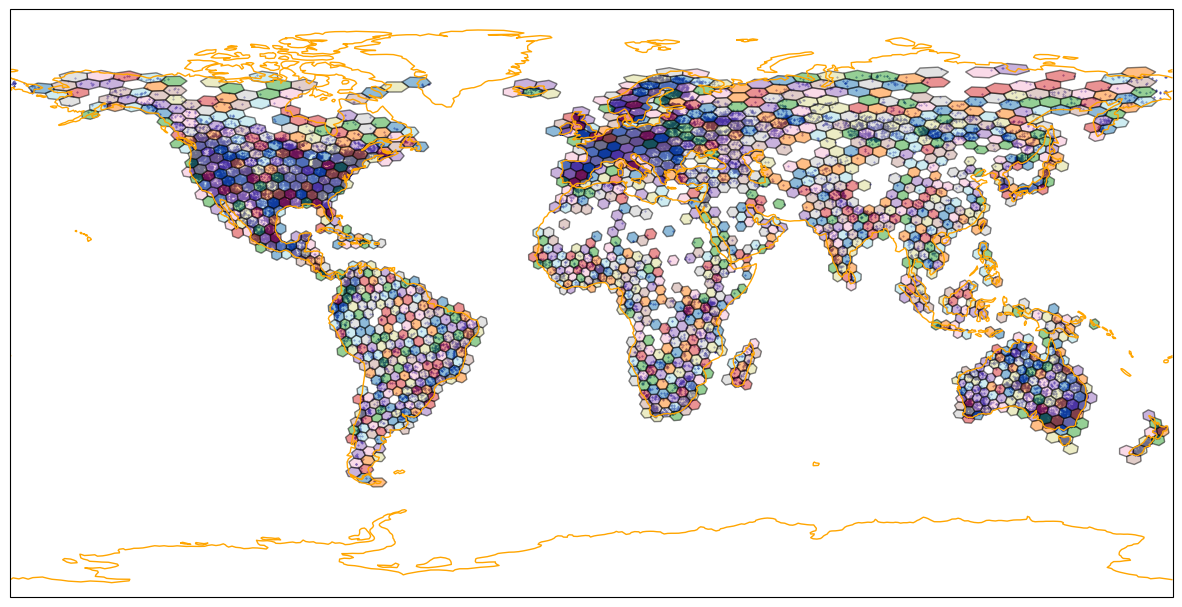

In [25]:
def crosses_antimeridian(polygon):
    # Get x-coordinates of the polygon
    x_coords = [x for x, y in polygon.exterior.coords]

    # Check if the polygon has x-coordinates both greater than 150 and less than -150
    return any(x > 150 for x in x_coords) and any(x < -150 for x in x_coords)


def plot_hexagons_and_points(df):
    # Convert hexagon IDs to polygons
    hexagons = df["hex_id"].unique()
    hex_coords = [(h, h3.h3_to_geo_boundary(h, geo_json=True)) for h in hexagons]
    hex_polygons = [(h, Polygon(coords)) for h, coords in hex_coords]

    # Handle polygons that cross the antimeridian
    hex_polygons = [
        (h, polygon) for h, polygon in hex_polygons if not crosses_antimeridian(polygon)
    ]

    # Create GeoDataFrame with hex_id column
    hex_gdf = gpd.GeoDataFrame(
        hex_polygons,
        columns=["hex_id", "geometry"],
        geometry="geometry",
        crs="EPSG:4326",
    )

    # Convert points to GeoDataFrame
    points_gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df["x"], df["y"]), crs="EPSG:4326"
    )

    hex_id_to_fold = df.drop_duplicates("hex_id").set_index("hex_id")["fold"].to_dict()
    hex_gdf["fold"] = hex_gdf["hex_id"].map(hex_id_to_fold)

    # Plot
    fig, ax = plt.subplots(
        figsize=(15, 10),
        subplot_kw={"projection": ccrs.PlateCarree()},
    )
    ax.set_global()
    ax.coastlines(color="orange")
    points_gdf.plot(
        ax=ax, markersize=0.2, color="darkblue", alpha=0.7, transform=ccrs.PlateCarree()
    )
    hex_gdf.plot(
        ax=ax,
        column="fold",
        cmap="tab20",
        edgecolor="black",
        transform=ccrs.PlateCarree(),
        alpha=0.5,
    )
    plt.show()

    return hex_gdf


hex_gdf = plot_hexagons_and_points(df)